<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter13/Customizing_StyleGAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if not os.path.exists('pytorch_stylegan_encoder'):
    !git clone https://github.com/jacobhallberg/pytorch_stylegan_encoder.git
    %cd pytorch_stylegan_encoder
    !git submodule update --init --recursive
    !wget -q https://github.com/jacobhallberg/pytorch_stylegan_encoder/releases/download/v1.0/trained_models.zip
    !unzip -q trained_models.zip
    !rm trained_models.zip
    !pip install -qU torch_snippets
    !mv trained_models/stylegan_ffhq.pth InterFaceGAN/models/pretrain
else:
    %cd pytorch_stylegan_encoder
    
from torch_snippets import *

Cloning into 'pytorch_stylegan_encoder'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 358 (delta 40), reused 15 (delta 6), pack-reused 287
Receiving objects: 100% (358/358), 56.89 MiB | 19.93 MiB/s, done.
Resolving deltas: 100% (179/179), done.
/content/pytorch_stylegan_encoder
Submodule 'InterFaceGAN' (git://github.com/ShenYujun/InterFaceGAN.git) registered for path 'InterFaceGAN'
Cloning into '/content/pytorch_stylegan_encoder/InterFaceGAN'...
Submodule path 'InterFaceGAN': checked out 'b707e942187f464251f855c92f7009b8cf13bf03'
     |████████████████████████████████| 36.7MB 82kB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 102kB 13.9MB/s 


In [ ]:
from InterFaceGAN.models.stylegan_generator import StyleGANGenerator
from models.latent_optimizer import PostSynthesisProcessing

synthesizer = StyleGANGenerator("stylegan_ffhq").model.synthesis
mapper = StyleGANGenerator("stylegan_ffhq").model.mapping
trunc = StyleGANGenerator("stylegan_ffhq").model.truncation

[2020-10-13 05:39:11,237][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2020-10-13 05:39:11,514][INFO] Successfully loaded!
[2020-10-13 05:39:11,516][INFO]   `lod` of the loaded model is 0.0.
[2020-10-13 05:39:21,174][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2020-10-13 05:39:21,438][INFO] Successfully loaded!
[2020-10-13 05:39:21,439][INFO]   `lod` of the loaded model is 0.0.
[2020-10-13 05:39:21,693][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2020-10-13 05:39:21,926][INFO] Successfully loaded!
[2020-10-13 05:39:21,927][INFO]   `lod` of the loaded model is 0.0.


In [ ]:
post_processing = PostSynthesisProcessing()
post_process = lambda image: post_processing(image).detach().cpu().numpy().astype(np.uint8)[0]

def latent2image(latent):
    img = post_process(synthesizer(latent))
    img = img.transpose(1,2,0)
    return img

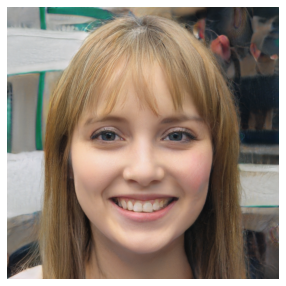

In [ ]:
rand_latents = torch.randn(1,512).cuda()
show(latent2image(trunc(mapper(rand_latents))), sz=5)

In [ ]:
!wget -q https://www.dropbox.com/s/lpw10qawsc5ipbn/MyImage.JPG -O MyImage.jpg
!git clone https://github.com/Puzer/stylegan-encoder.git
!mkdir -p stylegan-encoder/raw_images
!mkdir -p stylegan-encoder/aligned_images
!mv MyImage.jpg stylegan-encoder/raw_images

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 105, done.
remote: Total 105 (delta 0), reused 0 (delta 0), pack-reused 105
Receiving objects: 100% (105/105), 10.39 MiB | 10.51 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [ ]:
!python stylegan-encoder/align_images.py stylegan-encoder/raw_images/ stylegan-encoder/aligned_images/
!mv stylegan-encoder/aligned_images/* ./MyImage.jpg

2020-10-13 05:42:04.958242: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
64045056/64040097 [==============================] - 38s 1us/step


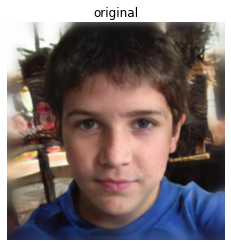

Optimizing Latents.
[2020-10-13 05:54:26,513][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2020-10-13 05:54:26,773][INFO] Successfully loaded!
[2020-10-13 05:54:26,773][INFO]   `lod` of the loaded model is 0.0.
Step: 2999, Loss: 1.732578992843628: 100% 3000/3000 [11:01<00:00,  4.53it/s]


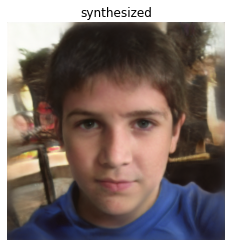

In [ ]:
from PIL import Image
img = Image.open('MyImage.jpg')
show(np.array(img), sz=4, title='original')

!python encode_image.py ./MyImage.jpg\
    pred_dlatents_myImage.npy\
    --use_latent_finder true\
    --image_to_latent_path ./trained_models/image_to_latent.pt

pred_dlatents = np.load('pred_dlatents_myImage.npy')
pred_dlatent = torch.from_numpy(pred_dlatents).float().cuda()
pred_image = latent2image(pred_dlatent)
show(pred_image, sz=4, title='synthesized')

2020-10-13 06:13:42.436 | INFO     | torch_snippets.loader:subplots:359 - plotting 4 images in a grid of 2x2 @ (7, 8)


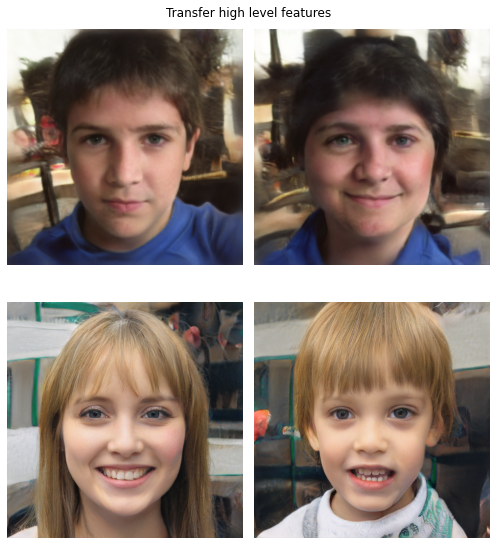

In [ ]:
idxs_to_swap = slice(0,3)
my_latents = torch.Tensor(np.load('pred_dlatents_myImage.npy', allow_pickle=True))

A, B = latent2image(my_latents.cuda()), latent2image(trunc(mapper(rand_latents)))
generated_image_latents = trunc(mapper(rand_latents))

x = my_latents.clone()
x[:,idxs_to_swap] = generated_image_latents[:,idxs_to_swap]
a = latent2image(x.float().cuda())

x = generated_image_latents.clone()
x[:,idxs_to_swap] = my_latents[:,idxs_to_swap]
b = latent2image(x.float().cuda())

subplots([A,a,B,b], figsize=(7,8), nc=2, suptitle='Transfer high level features')

In [ ]:
idxs_to_swap

slice(0, 2, None)

2020-10-13 06:13:52.663 | INFO     | torch_snippets.loader:subplots:359 - plotting 4 images in a grid of 2x2 @ (7, 8)


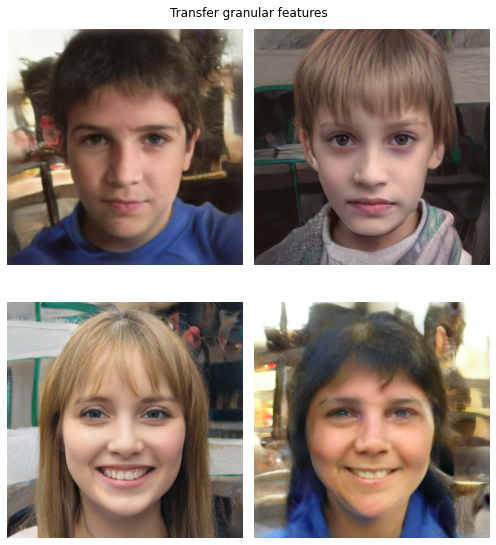

In [ ]:
idxs_to_swap = slice(4,15)
my_latents = torch.Tensor(np.load('pred_dlatents_myImage.npy', allow_pickle=True))

A, B = latent2image(my_latents.cuda()), latent2image(trunc(mapper(rand_latents)))
generated_image_latents = trunc(mapper(rand_latents))

x = my_latents.clone()
x[:,idxs_to_swap] = generated_image_latents[:,idxs_to_swap]
a = latent2image(x.float().cuda())

x = generated_image_latents.clone()
x[:,idxs_to_swap] = my_latents[:,idxs_to_swap]
b = latent2image(x.float().cuda())

subplots([A,a,B,b], figsize=(7,8), nc=2, suptitle='Transfer granular features')

2020-10-13 06:14:10.776 | INFO     | torch_snippets.loader:subplots:359 - plotting 4 images in a grid of 2x2 @ (7, 8)


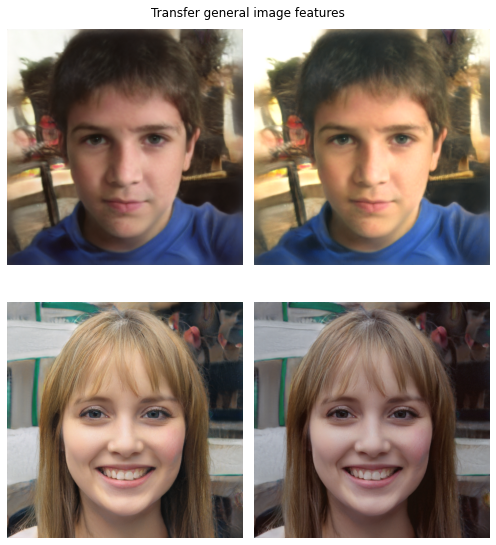

In [ ]:
idxs_to_swap = slice(16,18)
my_latents = torch.Tensor(np.load('pred_dlatents_myImage.npy', allow_pickle=True))

A, B = latent2image(my_latents.cuda()), latent2image(trunc(mapper(rand_latents)))
generated_image_latents = trunc(mapper(rand_latents))

x = my_latents.clone()
x[:,idxs_to_swap] = generated_image_latents[:,idxs_to_swap]
a = latent2image(x.float().cuda())

x = generated_image_latents.clone()
x[:,idxs_to_swap] = my_latents[:,idxs_to_swap]
b = latent2image(x.float().cuda())

subplots([A,a,B,b], figsize=(7,8), nc=2, suptitle='Transfer general image features')

[2020-10-13 06:17:20,651][INFO] Initializing generator.
[2020-10-13 06:17:20,887][INFO] Loading pytorch model from `InterFaceGAN/models/pretrain/stylegan_ffhq.pth`.
[2020-10-13 06:17:21,161][INFO] Successfully loaded!
[2020-10-13 06:17:21,161][INFO]   `lod` of the loaded model is 0.0.
[2020-10-13 06:17:24,246][INFO] Preparing boundary.
[2020-10-13 06:17:24,250][INFO] Preparing latent codes.
[2020-10-13 06:17:24,250][INFO]   Load latent codes from `pred_dlatents_myImage.npy`.
[2020-10-13 06:17:24,251][INFO] Editing 1 samples.
[2020-10-13 06:17:26,461][INFO] Successfully edited 1 samples.


2020-10-13 06:17:26.979 | INFO     | torch_snippets.loader:subplots:359 - plotting 20 images in a grid of 4x5 @ (10, 10)


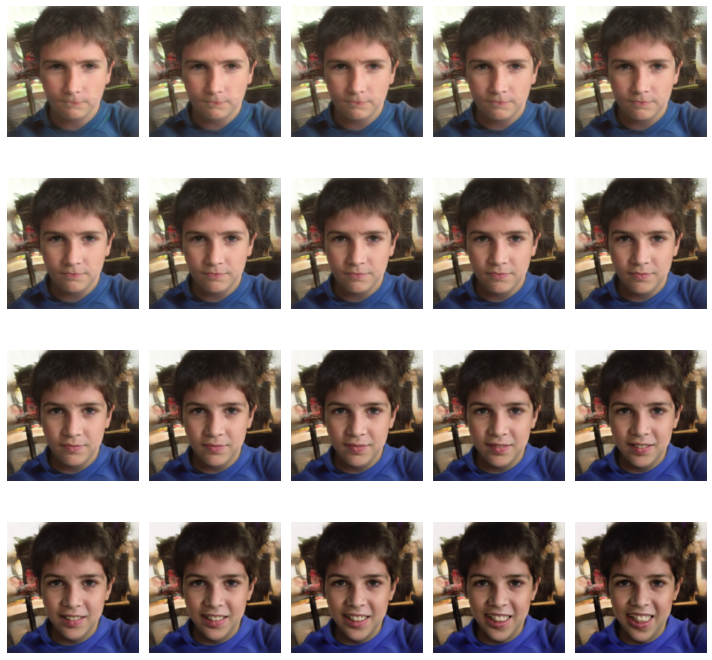

In [ ]:
!python InterFaceGAN/edit.py\
 -m stylegan_ffhq\
 -o results_new_smile\
 -b InterFaceGAN/boundaries/stylegan_ffhq_smile_w_boundary.npy\
 -i pred_dlatents_myImage.npy\
 -s WP\
 --steps 20

generated_faces = glob.glob('results_new_smile/*.jpg')

subplots([read(im,1) for im in sorted(generated_faces)],figsize=(10,10))